**Context**
preprocess and analyze our e-commerce dataset (CSV format)

**Goal**
1. Clean the data
2. Perform exploratory data analysis (EDA) with visualizations
3. Prepare it for machine learning modeling to segment customers based on purchase price range and product categories for targeted marketing strategies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Identify Numerical Column

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


From statistics above, we can see there is some errors in data like negative numbers for Quantity and Price.

In [5]:
numerical_columns = df.select_dtypes(exclude='O').columns
numerical_columns

Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')

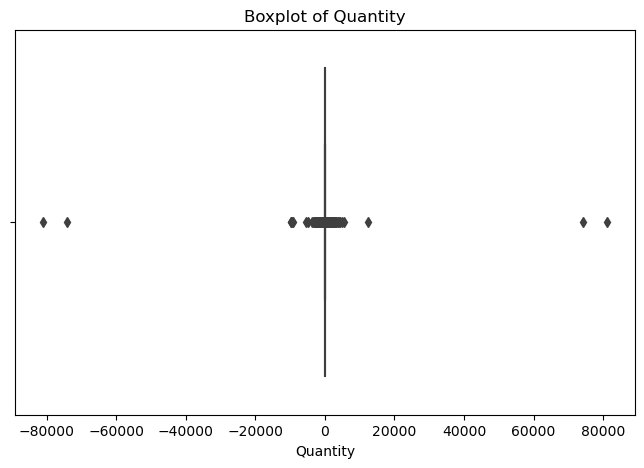

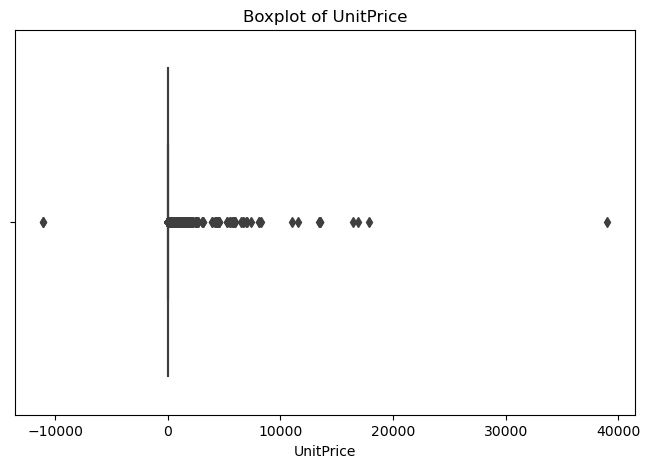

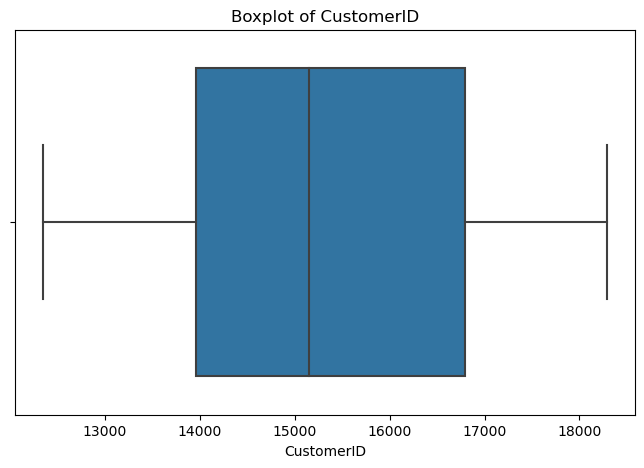

In [6]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))  # Set figure size for clarity
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')  # Add title for better understanding
    plt.show()

The plot shows that UnitPrice and Quantity has some outliers (very big value and very small value). We need to drop them.

In [7]:
df.duplicated().sum()

5268

It shows that data also have many duplicates. We need to drop those rows.

In [8]:
df[df['Quantity']>80000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom


In [9]:
df.CustomerID.nunique()

4372

Because what we will do is creating customer segmentation by clustering customer, the final data tha we would have is about 4372.

### Identify Categorical Column

In [10]:
df.describe(include='O')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


From statistics above, we can see that:
- Invoice is an identifier whenever someone makes a purchase and associated with each customer. Each customer may have more than one Invoice. So **we can derive useful features from this, like 'Frequency' that shows how many times each customer makes purchase.**
- StockCode is unique and can be used extracted as **Product Categories**
- Description is a text feature, so it may not really useful for our clustering purpose. SO we will ignore it.
- We can use InvoiceDate to extract new information like **Duration: last purchase - first purchase**
- Country is dominated with UK almost 90% is UK therefore we don't use this feature

### Clean Data
- Change negative values to positive
- Remove outliers
- Remove duplicates


In [11]:
df.loc[df['Quantity']<0, 'Quantity'] = -1 * df['Quantity']

In [12]:
df.loc[df['UnitPrice']<0, 'UnitPrice'] = -1 * df['UnitPrice']

#### Remove Outliers

In [13]:
# remove outliers in Quantity
Q1 = df.Quantity.quantile(0.25)
Q3 = df.Quantity.quantile(0.75)
IQR = Q3-Q1
print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print(f'Lower limit Quantity: {lower_limit}, Upper limit Quantity: {upper_limit}')

df = df[(df.Quantity > lower_limit) & (df.Quantity < upper_limit)]

Q1: 1.0, Q3: 10.0, IQR: 9.0
Lower limit Quantity: -12.5, Upper limit Quantity: 23.5


In [14]:
# remove outliers in Quantity
Q1 = df.UnitPrice.quantile(0.25)
Q3 = df.UnitPrice.quantile(0.75)
IQR = Q3-Q1
print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
print(f'Lower limit UnitPrice: {lower_limit}, Upper limit UnitPrice: {upper_limit}')

df = df[(df.UnitPrice > lower_limit) & (df.UnitPrice < upper_limit)]

Q1: 1.25, Q3: 4.15, IQR: 2.9000000000000004
Lower limit UnitPrice: -3.1000000000000005, Upper limit UnitPrice: 8.5


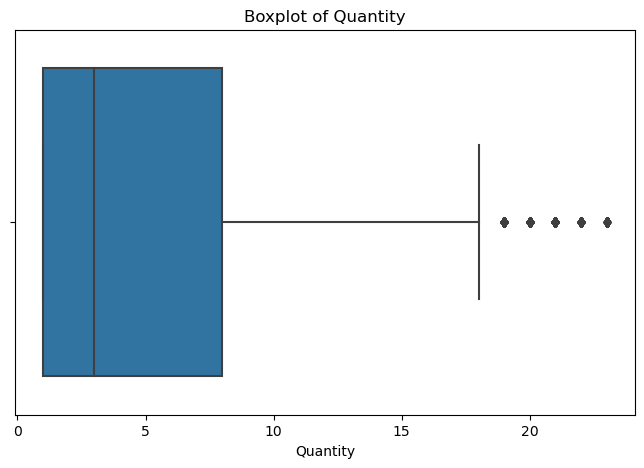

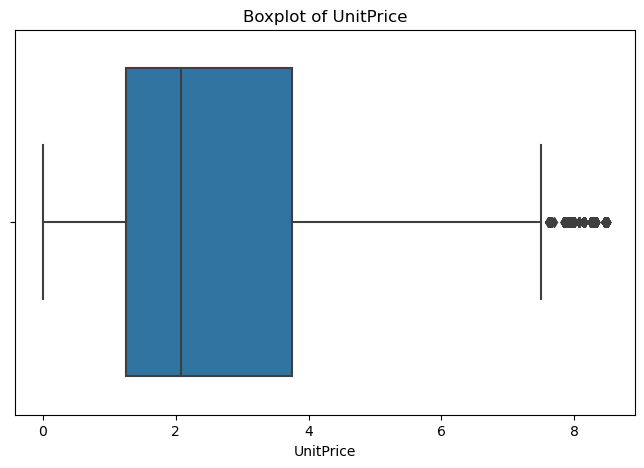

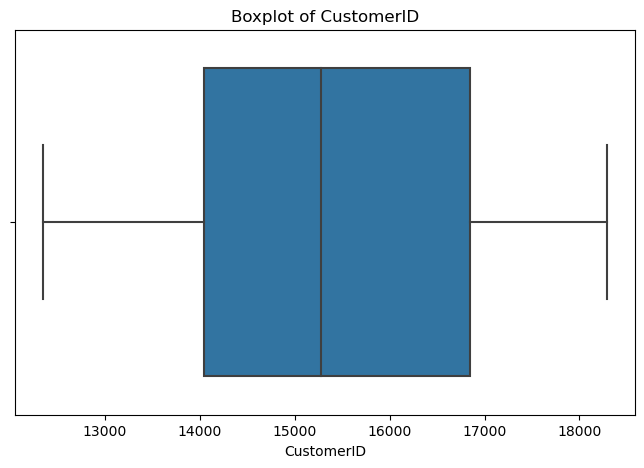

In [15]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))  # Set figure size for clarity
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')  # Add title for better understanding
    plt.show()

In [16]:
print(f'Before: {df.duplicated().sum()} duplicates')

df = df.drop_duplicates()

print(f'After: {df.duplicated().sum()} duplicates')

Before: 4973 duplicates
After: 0 duplicates


### Feature Engineering
Transform data into row per customers aggregate using group by CustomerID
1. Transform date to datetime type
2. Exclude Description and Country
3. Get stock code per customer, make it list for each customer
4. Get Duration = last invoice - first invoice Date per customer 
5. Groupby data by Customer, aggregate count InvoiceNo, sum() Quantity, sum() UnitPrice
6. Concat data stock code product, Duration, and groupby results

In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [18]:
df = df.drop(['Description', 'Country'], axis=1)

In [19]:
df.head(3)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0


In [20]:
df['StockCode'].unique().tolist()

['85123A',
 '71053',
 '84406B',
 '84029G',
 '84029E',
 '22752',
 '21730',
 '22633',
 '22632',
 '22745',
 '22748',
 '22749',
 '22310',
 '84969',
 '22623',
 '21754',
 '21755',
 '21777',
 '48187',
 '22960',
 '22913',
 '22912',
 '22914',
 '21756',
 '22726',
 '21724',
 '21035',
 '22661',
 '21913',
 '20679',
 '37370',
 '21871',
 '21071',
 '21068',
 '82483',
 '82486',
 '82482',
 '82494L',
 '22386',
 '85099C',
 '21033',
 '20723',
 '84997B',
 '84997C',
 '21094',
 '20725',
 '21559',
 '22352',
 '84519A',
 '21931',
 '21929',
 '22139',
 '84854',
 '22411',
 '82567',
 '21672',
 '71270',
 '22262',
 '22637',
 '21934',
 '21169',
 '21166',
 '21175',
 '37444A',
 '37444C',
 '22086',
 '22083',
 '84971S',
 '47580',
 '22261',
 '84832',
 '22644',
 '21533',
 '21557',
 '15056BL',
 '15056N',
 '22646',
 '22176',
 '22438',
 '21731',
 '22778',
 '21523',
 '10002',
 '21912',
 '21832',
 '22379',
 '22798',
 '22926',
 '35004C',
 '82484',
 '22464',
 '21324',
 '22457',
 '22224',
 '22189',
 '22427',
 '22428',
 '22961',
 '22

In [21]:
# get product number from StockCode
import regex as re

df['ProductNo'] = df['StockCode'].str.extract('(\d)')
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,ProductNo
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,8
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,7
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,8
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,8
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,8


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440528 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    440528 non-null  object        
 1   StockCode    440528 non-null  object        
 2   Quantity     440528 non-null  int64         
 3   InvoiceDate  440528 non-null  datetime64[ns]
 4   UnitPrice    440528 non-null  float64       
 5   CustomerID   322806 non-null  float64       
 6   ProductNo    440141 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 26.9+ MB


Some features have missing values like CustomerID and ProductNo, hence we drop those rows.

In [23]:
df = df.dropna()

In [24]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
ProductNo      0
dtype: int64

In [25]:
df['ProductNo'].unique()

array(['8', '7', '2', '4', '3', '1', '9', '5', '6'], dtype=object)

In [26]:
df.groupby('ProductNo', as_index=False)['UnitPrice'].sum()

,ProductNo,UnitPrice
0,1,7931.81
1,2,663574.49
2,3,4994.51
3,4,39277.73
4,5,208.20
5,6,136.70
6,7,10147.90
7,8,82852.00
8,9,4467.15


ProductNo seems useful, as it indicates that some products are purchased more frequently than others. Then, we can drop StockCode

In [27]:
df = df.drop('StockCode', axis=1)
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,ProductNo
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,8
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,7
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,8
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,8
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,8


In [28]:
# Make ProductNo becomes list for each CustomerID

customers = df['CustomerID'].unique()
customer_products_dict = {}

for customer in customers:
    products = df.loc[df['CustomerID'] == customer, 'ProductNo'].unique().tolist()
    customer_products_dict[customer] = products

customer_products = pd.DataFrame(list(customer_products_dict.items()), columns=['CustomerID', 'Products'])

customer_products.head()


,CustomerID,Products
0,17850.0,"[8, 7, 2, 3, 1]"
1,13047.0,"[2, 8, 4]"
2,12583.0,"[2, 8]"
3,14688.0,"[2, 8, 4, 7, 1]"
4,15311.0,"[2, 8, 7, 3, 4, 1]"


In [29]:
customer_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4196 entries, 0 to 4195
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4196 non-null   float64
 1   Products    4196 non-null   object 
dtypes: float64(1), object(1)
memory usage: 65.7+ KB


In [30]:
cust_invoice_dates = df.loc[df['CustomerID']==17850.0, 'InvoiceDate']
cust_invoice_dates.max()

Timestamp('2011-02-10 14:38:00')

In [31]:
# get Duration per customer

customers = df['CustomerID'].unique()
customer_duration_dict = {}

for customer in customers:
    cust_invoice_dates = df.loc[df['CustomerID']==customer, 'InvoiceDate']
    
    duration = (cust_invoice_dates.max() - cust_invoice_dates.min()).days
    customer_duration_dict[customer] = duration
    
customer_durations = pd.DataFrame(list(customer_duration_dict.items()), columns=['CustomerID', 'Duration'])

customer_durations.head()

,CustomerID,Duration
0,17850.0,71
1,13047.0,327
2,12583.0,370
3,14688.0,366
4,15311.0,373


Then, we drop ProductNo and InvoiceDate 

In [32]:
df = df.drop(['ProductNo', 'InvoiceDate'], axis=1)
df.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID
0,536365,6,2.55,17850.0
1,536365,6,3.39,17850.0
2,536365,8,2.75,17850.0
3,536365,6,3.39,17850.0
4,536365,6,3.39,17850.0


In [33]:
customer_df = df.groupby('CustomerID', as_index=False).agg({
    'InvoiceNo': 'count',        
    'Quantity': 'sum',
    'UnitPrice': 'sum'
})

customer_df.head()

,CustomerID,InvoiceNo,Quantity,UnitPrice
0,12347.0,141,1281,375.34
1,12348.0,1,20,0.85
2,12349.0,61,473,199.06
3,12350.0,15,172,24.45
4,12352.0,74,565,231.20


In [34]:
# concat customer_products_list, customer_duration, and customer_df

customer_df = pd.merge(customer_df, customer_products, on='CustomerID').merge(customer_durations, on='CustomerID')

In [35]:
customer_df.head()

,CustomerID,InvoiceNo,Quantity,UnitPrice,Products,Duration
0,12347.0,141,1281,375.34,"[8, 2, 7, 4, 5]",365
1,12348.0,1,20,0.85,[2],0
2,12349.0,61,473,199.06,"[2, 4, 8, 3]",0
3,12350.0,15,172,24.45,"[2, 7, 8]",0
4,12352.0,74,565,231.20,"[2, 8, 3]",260


In [36]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4196 entries, 0 to 4195
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4196 non-null   float64
 1   InvoiceNo   4196 non-null   int64  
 2   Quantity    4196 non-null   int64  
 3   UnitPrice   4196 non-null   float64
 4   Products    4196 non-null   object 
 5   Duration    4196 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 229.5+ KB


### Encoding Product

In [37]:
codes = range(1,10)
print(codes)

for code in codes:
    customer_df[f'Product{code}'] = 0


range(1, 10)


In [38]:
customer_df.head()

,CustomerID,InvoiceNo,Quantity,UnitPrice,Products,Duration,Product1,Product2,Product3,Product4,Product5,Product6,Product7,Product8,Product9
0,12347.0,141,1281,375.34,"[8, 2, 7, 4, 5]",365,0,0,0,0,0,0,0,0,0
1,12348.0,1,20,0.85,[2],0,0,0,0,0,0,0,0,0,0
2,12349.0,61,473,199.06,"[2, 4, 8, 3]",0,0,0,0,0,0,0,0,0,0
3,12350.0,15,172,24.45,"[2, 7, 8]",0,0,0,0,0,0,0,0,0,0
4,12352.0,74,565,231.20,"[2, 8, 3]",260,0,0,0,0,0,0,0,0,0


In [39]:
def set_product_flags(row):
    for code in row['Products']:
        row[f'Product{code}'] = 1
    return row

customer_df = customer_df.apply(set_product_flags, axis=1)

In [40]:
customer_df = customer_df.drop(['CustomerID', 'Products'], axis=1)

In [41]:
customer_df.head()

,InvoiceNo,Quantity,UnitPrice,Duration,Product1,Product2,Product3,Product4,Product5,Product6,Product7,Product8,Product9
0,141,1281,375.34,365,0,1,0,1,1,0,1,1,0
1,1,20,0.85,0,0,1,0,0,0,0,0,0,0
2,61,473,199.06,0,0,1,1,1,0,0,0,1,0
3,15,172,24.45,0,0,1,0,0,0,0,1,1,0
4,74,565,231.20,260,0,1,1,0,0,0,0,1,0


In [42]:
# renmae columns

column_names = {
    'InvoiceNo': 'TotalInvoice',
    'Quantity': 'TotalItem',
    'UnitPrice': 'TotalPrice',
}

customer_df = customer_df.rename(columns=column_names)

In [43]:
customer_df.head()

,TotalInvoice,TotalItem,TotalPrice,Duration,Product1,Product2,Product3,Product4,Product5,Product6,Product7,Product8,Product9
0,141,1281,375.34,365,0,1,0,1,1,0,1,1,0
1,1,20,0.85,0,0,1,0,0,0,0,0,0,0
2,61,473,199.06,0,0,1,1,1,0,0,0,1,0
3,15,172,24.45,0,0,1,0,0,0,0,1,1,0
4,74,565,231.20,260,0,1,1,0,0,0,0,1,0


#### Scale Data

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_df['TotalInvoice'] = scaler.fit_transform(customer_df[['TotalInvoice']])
customer_df['TotalItem'] = scaler.fit_transform(customer_df[['TotalItem']])
customer_df['TotalPrice'] = scaler.fit_transform(customer_df[['TotalPrice']])
customer_df['Duration'] = scaler.fit_transform(customer_df[['Duration']])

customer_df.head()

,TotalInvoice,TotalItem,TotalPrice,Duration,Product1,Product2,Product3,Product4,Product5,Product6,Product7,Product8,Product9
0,0.019014,0.036522,0.023307,0.978552,0,1,0,1,1,0,1,1,0
1,0.000000,0.000542,0.000019,0.000000,0,1,0,0,0,0,0,0,0
2,0.008149,0.013468,0.012345,0.000000,0,1,1,1,0,0,0,1,0
3,0.001901,0.004879,0.001486,0.000000,0,1,0,0,0,0,1,1,0
4,0.009914,0.016093,0.014343,0.697051,0,1,1,0,0,0,0,1,0


## Modelling

In [45]:
from sklearn.cluster import KMeans

In [46]:
k_range = range(1,100)
SSE = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit_predict(customer_df)
    SSE.append(km.inertia_)
    

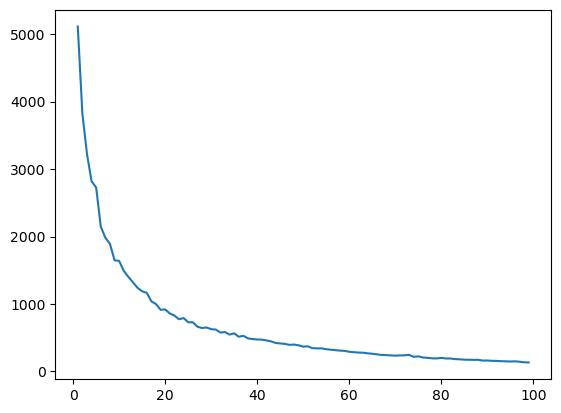

In [47]:
plt.plot(k_range, SSE)

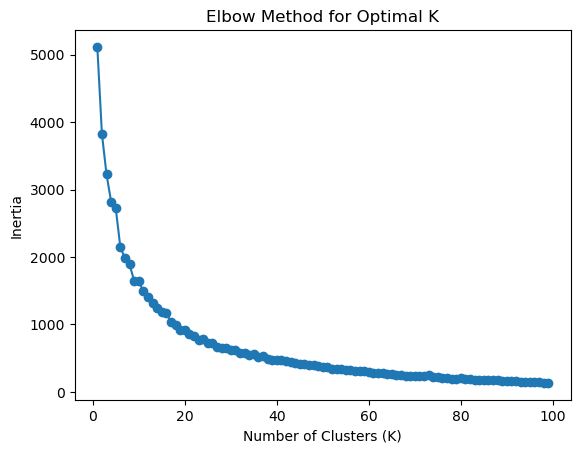

In [48]:
plt.plot(k_range, SSE, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [52]:
k_range = range(5,50)
SSE = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit_predict(customer_df)
    SSE.append(km.inertia_)
    

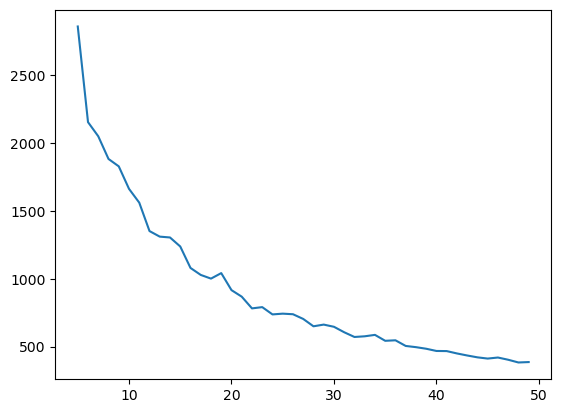

In [53]:
plt.plot(k_range, SSE)

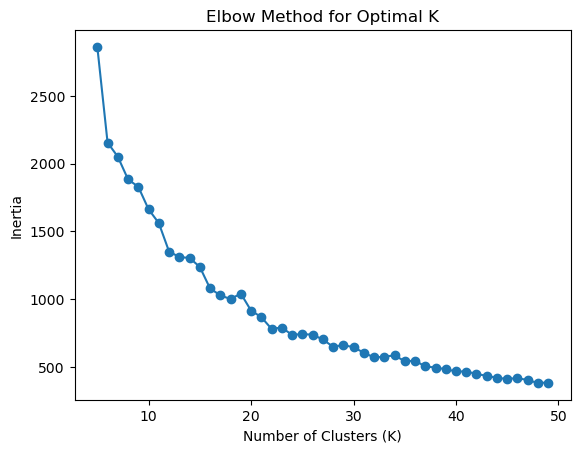

In [54]:
plt.plot(k_range, SSE, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

I guess the k is 15. Let's check using silhouette score

In [58]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

n_clusters = 15
km = KMeans(n_clusters=n_clusters, n_init='auto')
labels = km.fit_predict(customer_df)


# Calculate silhouette score
silhouette_avg = silhouette_score(customer_df, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.4829829769539674


The score indicates there is some overlapping between clusters.

For reference, [see this](https://www.kaggle.com/code/fabiendaniel/customer-segmentation)

# Check brainstorm

In [4]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64